## off-policy Every-Visit MC Control with weighted importance sampling


In [1]:
%matplotlib inline
import sys
from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib.utils.draw import show_policy_black,show_value_function
import matplotlib

matplotlib.style.use('ggplot')
env = BlackjackEnv()

In [2]:
def create_average_policy(nA):
    A = np.ones(nA,dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [3]:
def create_greed_policy(Q):
    
    def policy_fn(observation):
        A = np.zeros_like(Q[observation],dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    return policy_fn

In [4]:
def mc_control_weighted(env,num_episodes,behavior_policy,gamma=1.0):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    target_policy = create_greed_policy(Q)

    for i_episode in range(num_episodes):    
        if i_episode % 1000 == 0:
            print(f"\rEpisode :{i_episode/num_episodes * 100:.2f}%",end = "")
            sys.stdout.flush()
        
        state = env.reset()
        stack_state_action = []
        stack_reward = []
        
        while True:
            probs = behavior_policy(state)
            action = np.random.choice((range(len(probs))),p=probs)
            next_state, reward, done, _ = env.step(action)
            stack_state_action.append((state, action))
            stack_reward.append(reward)
            if done:
                break
            state = next_state
            
        size = len(stack_state_action)
        G = 0
        W = 1.0
        for i in range(size-1,-1,-1):
            state,action = stack_state_action[i]
            state = tuple(state)
            key = (state, action)
            
            G = gamma*G + stack_reward[i]
            
            C[state][action] += W
            Q[state][action] = Q[state][action] + (W / C[state][action]) * (G - Q[state][action])
            
            # 当 target 不是最优的时候为 0
            # W = 0 后面的所有都为 0 了就不用算了
            if action != np.argmax(target_policy(state)):
                break
            # 当 target 为最优的时候选择的概率为 1
            # 所以分子为 1.0 
            W = W * 1.0/behavior_policy(state)[action]
    return Q,target_policy

Episode :99.80%

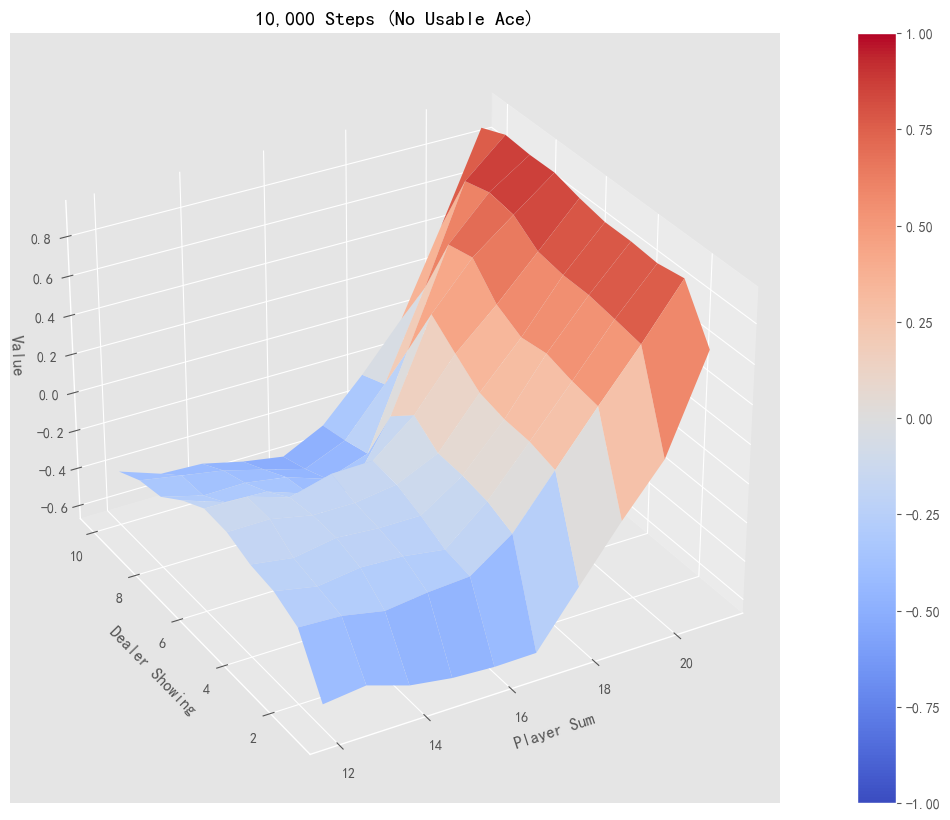

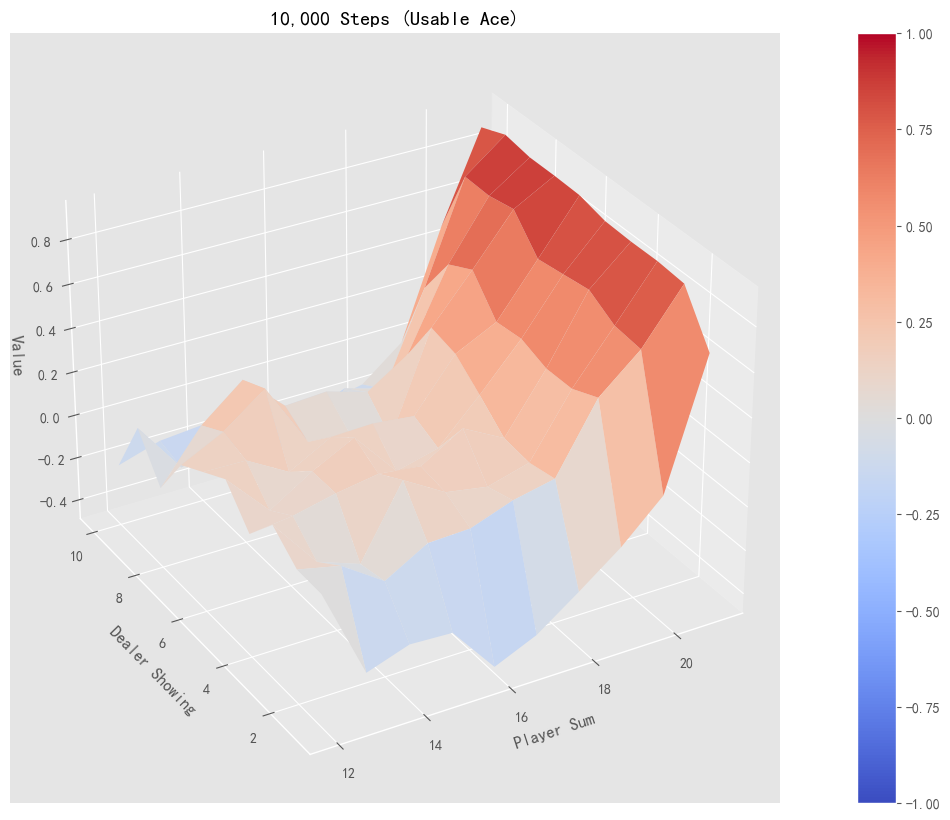

In [5]:
average_policy = create_average_policy(env.nA)
Q, policy = mc_control_weighted(env, num_episodes=500000,behavior_policy=average_policy)
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
show_value_function(V, title="10,000 Steps")

[[1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


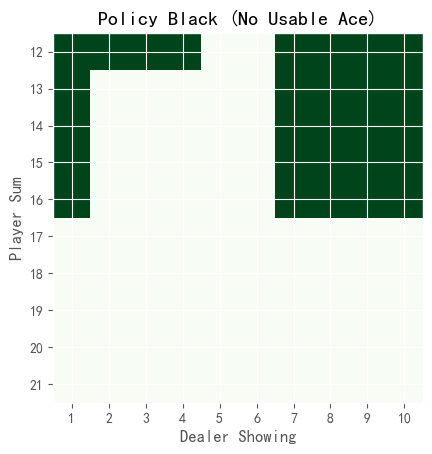

In [6]:

show_policy_black(policy,V)